# Centre of mass analysis

## Introduction

In this notebook we aimed to identify the centre-of-mass (COM) of the TCR framework (Fw) regions and the anchors of the CDR loops. We then investigated the amount of movement these regions undergo between *apo* and *holo* states. We also used these COMs to create an axis of the TCR and measure the angle between both chains of the TCR before determining the angle changes between *apo* and *holo* states.

In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_interface_analysis.measurements import get_distance
from tcr_pmhc_interface_analysis.processing import annotate_tcr_pmhc_df, find_anchors
from tcr_pmhc_interface_analysis.utils import get_coords

In [2]:
DATA_DIR = '../data/processed/apo-holo-tcr-pmhc-class-I'

In [3]:
apo_holo_summary_df = pd.read_csv(os.path.join(DATA_DIR, 'apo_holo_summary.csv'))
apo_holo_summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1,1b0g_C-A-B_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,C,A,B,NaN,ALWGFFPVL,hla_a_02_01
2,1b0g_F-D-E_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,F,D,E,NaN,ALWGFFPVL,hla_a_02_01
3,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
4,1bii_P-A-B_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
...,...,...,...,...,...,...,...,...,...,...,...,...
386,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,NaN,NaN,C,A,B,NaN,YLQPRTFLL,hla_a_02_01
387,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
388,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02
389,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02


In [4]:
complexes = [complex_id for complex_id in os.listdir(DATA_DIR)
                 if os.path.isdir(os.path.join(DATA_DIR, complex_id))]

## Computing Measurements

In [5]:
def calculate_angle(vec1, vec2):
    '''Caculate the angle between two vectors.'''
    return np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

In [6]:
complex_ids = []
structure_x_paths = []
structure_y_paths = []

alpha_anchor_com_diffs = []
beta_anchor_com_diffs = []

alpha_fw_com_diffs = []
beta_fw_com_diffs = []

chain_angle_diffs = []

for complex_id in complexes:
    complex_path = os.path.join(DATA_DIR, complex_id)
    complex_pdb_files = [file_ for file_ in os.listdir(complex_path) if file_.endswith('.pdb')]
    complex_summary = apo_holo_summary_df[apo_holo_summary_df['file_name'].isin(complex_pdb_files)]

    comparison_structures = complex_summary.query("structure_type == 'tcr' or state == 'holo'")
    comparisons = pd.merge(comparison_structures, comparison_structures, how='cross')
    comparisons['comparison'] = comparisons.apply(lambda row: '-'.join(sorted([row.file_name_x, row.file_name_y])),
                                                  axis='columns')
    comparisons = comparisons.drop_duplicates('comparison')
    comparisons = comparisons.drop('comparison', axis='columns')
    comparisons = comparisons.query('file_name_x != file_name_y')
    
    for _, comparison in comparisons.iterrows():
        tcrs = []
        for suffix in '_x', '_y':
            with open(os.path.join(complex_path, comparison['file_name' + suffix]), 'r') as fh:
                structure_df = parse_pdb_to_pandas(fh.read())

            chains = comparison.filter(like='chain').filter(regex=f'{suffix}$').replace({np.nan: None}).tolist()
            structure_df = annotate_tcr_pmhc_df(structure_df, *chains)

            structure_df['backbone'] = structure_df['atom_name'].map(
                lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O')
            )
            tcr_df = structure_df.query("chain_type in ['alpha_chain', 'beta_chain']").copy().reset_index()

            tcrs.append(tcr_df)

        tcr_x, tcr_y = tcrs

         # Compute C.O.Ms and coordinate vectors
        calculations = defaultdict(dict)

        for label, tcr_df in (('x', tcr_x), ('y', tcr_y)):
            for chain_type in ('alpha_chain', 'beta_chain'):
                anchors_ca = pd.DataFrame()

                for cdr in (1, 2, 3):
                    cdr_df = tcr_df.query('chain_type == @chain_type and cdr == @cdr')

                    for cdr_anchor in find_anchors(cdr_df, tcr_df):
                        anchors_ca = pd.concat([anchors_ca, cdr_anchor.query("atom_name == 'CA'")])

                fw_ca_df = tcr_df.query("cdr.isnull() and residue_seq_id <= 128 and chain_type == @chain_type and atom_name == 'CA'")

                anchors_com = np.average(get_coords(anchors_ca), axis=0)
                fw_com = np.average(get_coords(fw_ca_df), axis=0)

                tcr_chain_direction_vec = fw_com - anchors_com

                calculations[label][chain_type] = {}

                calculations[label][chain_type]['anchors_com'] = anchors_com
                calculations[label][chain_type]['fw_com'] = fw_com
                calculations[label][chain_type]['direction_vector'] = tcr_chain_direction_vec

        # Calculate differences
        chain_anchor_com = []
        chain_fw_com = []
        for chain_type in ('alpha_chain', 'beta_chain'):
            chain_anchor_com.append(get_distance(calculations['x'][chain_type]['anchors_com'],
                                                 calculations['y'][chain_type]['anchors_com']))

            chain_fw_com.append(get_distance(calculations['x'][chain_type]['fw_com'],
                                             calculations['y'][chain_type]['fw_com']))


        angle_x = calculate_angle(calculations['x']['alpha_chain']['direction_vector'],
                                    calculations['x']['beta_chain']['direction_vector'])

        angle_y = calculate_angle(calculations['y']['alpha_chain']['direction_vector'],
                                     calculations['y']['beta_chain']['direction_vector'])

        angle_diff = angle_y - angle_x

        # Collect Data
        complex_ids.append(complex_id)
        structure_x_paths.append(comparison['file_name_x'])
        structure_y_paths.append(comparison['file_name_y'])

        alpha_anchor_com_diffs.append(chain_anchor_com[0])
        beta_anchor_com_diffs.append(chain_anchor_com[1])

        alpha_fw_com_diffs.append(chain_fw_com[0])
        beta_fw_com_diffs.append(chain_fw_com[1])

        chain_angle_diffs.append(angle_diff)

results = pd.DataFrame({
    'complex_id': complex_ids,
    'structure_x_path': structure_x_paths,
    'structure_y_path': structure_y_paths,
    'alpha_anchor_com_diff': alpha_anchor_com_diffs,
    'beta_anchor_com_diff': beta_anchor_com_diffs,
    'alpha_fw_com_diff': alpha_fw_com_diffs,
    'beta_fw_com_diff': beta_fw_com_diffs, 
    'chain_angle_diff': chain_angle_diffs,
})
results

,complex_id,structure_x_path,structure_y_path,alpha_anchor_com_diff,beta_anchor_com_diff,alpha_fw_com_diff,beta_fw_com_diff,chain_angle_diff
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,0.645120,0.457327,0.219777,0.166987,-0.033421
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_D-E_tcr.pdb,0.527090,0.340932,0.164026,0.213055,-0.040502
2,3qdg_D-E-C-A-B_tcr_pmhc,3qeu_A-B_tcr.pdb,3qeu_D-E_tcr.pdb,0.682250,0.284114,0.334339,0.064055,-0.007081
3,5c0a_D-E-C-A-B_tcr_pmhc,3utp_D-E_tcr.pdb,3utp_K-L_tcr.pdb,0.304534,0.602875,0.290645,0.338509,0.041175
4,5c0a_D-E-C-A-B_tcr_pmhc,3utp_D-E_tcr.pdb,5c0a_D-E-C-A-B_tcr_pmhc.pdb,0.292352,0.514781,0.334429,0.270019,0.032863
...,...,...,...,...,...,...,...,...
131,5nme_D-E-C-A-B_tcr_pmhc,5nmd_C-D_tcr.pdb,5nme_D-E-C-A-B_tcr_pmhc.pdb,0.211336,0.712433,0.113214,0.130459,0.030224
132,5hhm_D-E-C-A-B_tcr_pmhc,2vlm_D-E_tcr.pdb,5hhm_D-E-C-A-B_tcr_pmhc.pdb,0.886794,0.410827,0.467935,0.381336,-0.115053
133,3kpr_D-E-C-A-B_tcr_pmhc,1kgc_D-E_tcr.pdb,3kpr_D-E-C-A-B_tcr_pmhc.pdb,0.919506,0.270885,0.383752,0.151581,-0.026228
134,1oga_D-E-C-A-B_tcr_pmhc,1oga_D-E-C-A-B_tcr_pmhc.pdb,2vlm_D-E_tcr.pdb,0.944931,0.542110,0.291887,0.336729,0.107774


In [7]:
apo_holo_summary_df['ids'] = apo_holo_summary_df['file_name'].str.replace('.pdb', '')

/var/scratch/bmcmaste/2178229/ipykernel_2172418/2116153506.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  apo_holo_summary_df['ids'] = apo_holo_summary_df['file_name'].str.replace('.pdb', '')


In [8]:
results = results.merge(apo_holo_summary_df[['ids', 'cdr_sequences_collated', 'mhc_slug', 'peptide_sequence']],
                        how='left',
                        left_on='complex_id', right_on='ids')

In [9]:
results = results.merge(
    apo_holo_summary_df[['file_name', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_path', right_on='file_name',
).merge(
    apo_holo_summary_df[['file_name', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_path', right_on='file_name',
)

In [10]:
results['composite_name'] = results.apply(lambda row: '-'.join(sorted([row.structure_x_path, row.structure_y_path])), axis='columns')
results = results.drop_duplicates('composite_name')

In [11]:
apo_holo_results = results.query('state_x != state_y')

In [12]:
apo_holo_results_norm = apo_holo_results.groupby('cdr_sequences_collated').agg({
    'alpha_anchor_com_diff': 'mean',
    'beta_anchor_com_diff': 'mean',
    'alpha_fw_com_diff': 'mean',
    'beta_fw_com_diff': 'mean',
    'chain_angle_diff': 'mean',
})

In [13]:
apo_holo_results_norm['chain_angle_diff_deg'] = apo_holo_results_norm['chain_angle_diff'].apply(np.degrees)
apo_holo_results_norm['chain_angle_diff_deg_mag'] = apo_holo_results_norm['chain_angle_diff_deg'].apply(np.abs)

In [14]:
apo_holo_results_norm

,alpha_anchor_com_diff,beta_anchor_com_diff,alpha_fw_com_diff,beta_fw_com_diff,chain_angle_diff,chain_angle_diff_deg,chain_angle_diff_deg_mag
cdr_sequences_collated,,,,,,,
ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGRGDQPQH,0.112478,0.221407,0.131706,0.140118,-0.005545,-0.317697,0.317697
DRGSQS-IYSNGD-ALTRGPGNQFY-SGHVS-FNYEAQ-ASSSPGGVSTEAF,1.606143,0.370279,1.293890,0.279836,-0.057826,-3.313194,3.313194
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,0.626083,0.366441,0.250095,0.178326,-0.001998,-0.114483,0.114483
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,0.624668,0.204869,0.302308,0.186851,-0.011943,-0.684280,0.684280
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY,0.306039,0.615471,0.133071,0.205778,0.024796,1.420686,1.420686
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAGGRPEQY,0.385751,0.657747,0.300314,0.374858,0.018630,1.067402,1.067402
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY,1.099042,0.294167,0.235768,0.174727,0.103824,5.948649,5.948649
DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTGINYGYT,0.596772,0.032190,0.184380,0.213406,-0.037547,-2.151258,2.151258
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDTGELF,0.264265,0.248560,0.103594,0.098554,-0.009340,-0.535154,0.535154


## Visualizing Results

### Changes in Framework (Fw) region and Loop Anchor Centre of Masses (COM)

In [15]:
coms = apo_holo_results_norm.melt(value_vars=['alpha_anchor_com_diff', 'beta_anchor_com_diff', 'alpha_fw_com_diff', 'beta_fw_com_diff'],
                                  var_name='location',
                                  value_name='com_diff')

coms['chain_type'] = coms['location'].map(lambda location: location.split('_')[0])
coms['location'] = coms['location'].map(lambda location: location.split('_')[1])

<AxesSubplot: xlabel='location', ylabel='com_diff'>

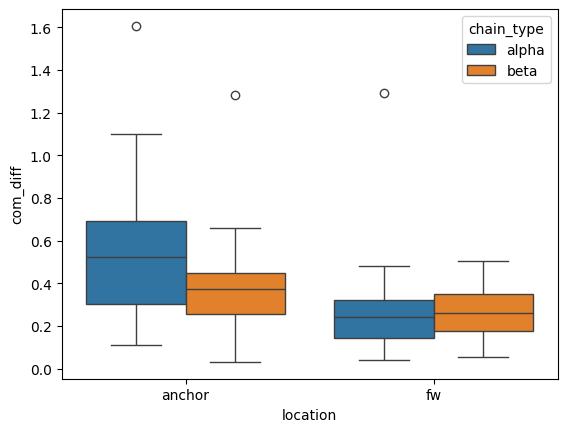

In [16]:
sns.boxplot(coms, y='com_diff', x='location', hue='chain_type')

There is slight movement between the COMs but not very much.

### Changes in angle between $\alpha$- and $\beta$- chain

count    22.000000
mean      0.014409
std       0.043607
min      -0.057826
25%      -0.009572
50%       0.011616
75%       0.026917
max       0.112168
Name: chain_angle_diff, dtype: float64

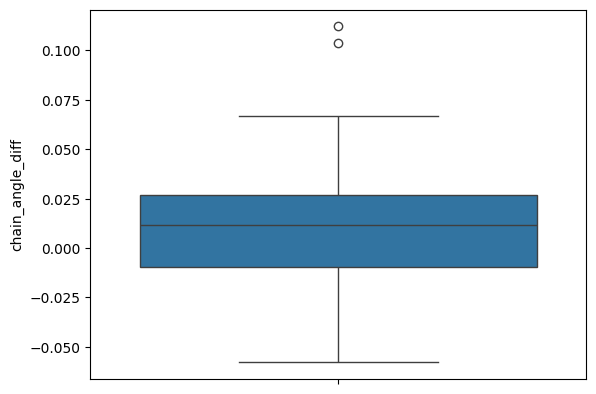

In [17]:
sns.boxplot(apo_holo_results_norm, y='chain_angle_diff')
apo_holo_results_norm['chain_angle_diff'].describe()

count    22.000000
mean      0.825593
std       2.498524
min      -3.313194
25%      -0.548427
50%       0.665530
75%       1.542237
max       6.426748
Name: chain_angle_diff_deg, dtype: float64

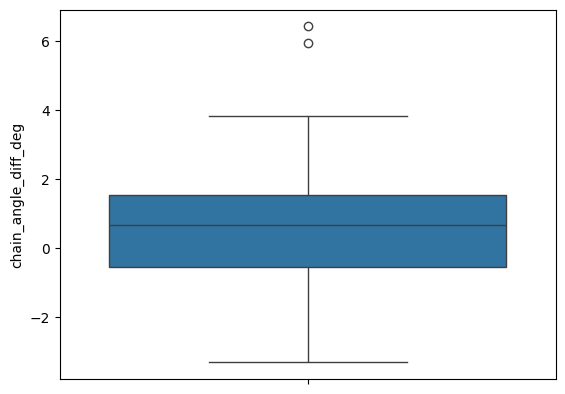

In [18]:
sns.boxplot(apo_holo_results_norm, y='chain_angle_diff_deg')
apo_holo_results_norm['chain_angle_diff_deg'].describe()

count    22.000000
mean      1.887715
std       1.795418
min       0.114483
25%       0.579086
50%       1.214819
75%       3.036777
max       6.426748
Name: chain_angle_diff_deg_mag, dtype: float64

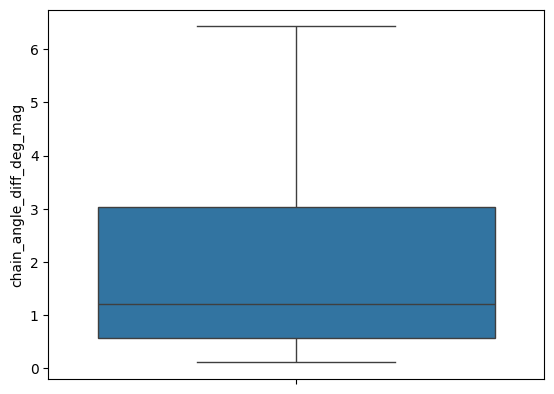

In [19]:
sns.boxplot(apo_holo_results_norm, y='chain_angle_diff_deg_mag')
apo_holo_results_norm['chain_angle_diff_deg_mag'].describe()

From these plots, it does not seem that their is a lot of angular change between domains.

## Conclusion

Based on the results of this analysis, the TCR Fw region remains fairly static between *apo* and *holo*.